In [1]:
using PorousMaterials
using Printf
using NPZ
using PyPlot
using ProgressMeter
using LightGraphs
using DelimitedFiles
using Random

In [2]:
import PorousMaterials.write_cif
"""
    write_cif(crystal, filename; fractional_coords=true)

Write a `crystal::Crystal` to a .cif file with `filename::AbstractString`. If `filename` does
not include the .cif extension, it will automatically be added. the `fractional_coords` flag 
allows us to write either fractional or Cartesian coordinates.
"""
function write_cif(crystal::Crystal, filename::AbstractString; fractional_coords::Bool=true, more_decimal_points::Bool=false)
    if has_charges(crystal)
        if crystal.atoms.n != crystal.charges.n
            error("write_cif assumes equal numbers of Charges and Atoms (or zero charges)")
        end
        if ! isapprox(crystal.charges.coords, crystal.atoms.coords)
            error("write_cif needs coords of atoms and charges to correspond.")
        end
    end

    # TODO is this labeling necessary for the bonds, arthur?
    # create dictionary for tracking label numbers
    label_numbers = Dict{Symbol, Int}()
    for atom in crystal.atoms.species
        if !haskey(label_numbers, atom)
            label_numbers[atom] = 1
        end
    end

    # append ".cif" to filename if it doesn't already have the extension
    if ! occursin(".cif", filename)
        filename *= ".cif"
    end  
    cif_file = open(filename, "w") 
    # first line should be data_xtalname_PM
    if crystal.name == ""
        @printf(cif_file, "data_PM\n")
    else 
        # don't include file extension!
        @printf(cif_file, "data_%s_PM\n", split(crystal.name, ".")[1])
    end  

    @printf(cif_file, "_symmetry_space_group_name_H-M\t'%s'\n", crystal.symmetry.space_group)

    @printf(cif_file, "_cell_length_a\t%f\n", crystal.box.a)
    @printf(cif_file, "_cell_length_b\t%f\n", crystal.box.b)
    @printf(cif_file, "_cell_length_c\t%f\n", crystal.box.c)

    @printf(cif_file, "_cell_angle_alpha\t%f\n", crystal.box.α * 180.0 / pi)
    @printf(cif_file, "_cell_angle_beta\t%f\n", crystal.box.β * 180.0 / pi)
    @printf(cif_file, "_cell_angle_gamma\t%f\n", crystal.box.γ * 180.0 / pi)

    @printf(cif_file, "_symmetry_Int_Tables_number 1\n\n")
    @printf(cif_file, "loop_\n_symmetry_equiv_pos_as_xyz\n")
    for i in 1:size(crystal.symmetry.operations, 2)
        @printf(cif_file, "'%s,%s,%s'\n", crystal.symmetry.operations[:, i]...)
    end  
    @printf(cif_file, "\n")

    @printf(cif_file, "loop_\n_atom_site_label\n_atom_site_type_symbol\n")
    if fractional_coords
        @printf(cif_file, "_atom_site_fract_x\n_atom_site_fract_y\n_atom_site_fract_z\n")
    else 
        @printf(cif_file, "_atom_site_Cartn_x\n_atom_site_Cartn_y\n_atom_site_Cartn_z\n")
    end  
    if has_charges(crystal)
        @printf(cif_file, "_atom_site_charge\n")
    end  

    idx_to_label = Array{AbstractString, 1}(undef, crystal.atoms.n)
    for i = 1:crystal.atoms.n
        # print label and type symbol
        @printf(cif_file, "%s\t%s\t", string(crystal.atoms.species[i]) *
                string(label_numbers[crystal.atoms.species[i]]),
                crystal.atoms.species[i])
        # store label for this atom idx
        idx_to_label[i] = string(crystal.atoms.species[i]) *
                    string(label_numbers[crystal.atoms.species[i]])
        # increment label
        label_numbers[crystal.atoms.species[i]] += 1 
        if fractional_coords
            @printf(cif_file, "%f\t%f\t%f", crystal.atoms.coords.xf[:, i]...)
        else
            @printf(cif_file, "%f\t%f\t%f", (crystal.box.f_to_c * crystal.atoms.coords.xf[:, i])...)
        end
        if has_charges(crystal)
            if more_decimal_points
                @printf(cif_file, "\t%.12f\n", crystal.charges.q[i])
            else
                @printf(cif_file, "\t%f\n", crystal.charges.q[i])
            end
        else
            @printf(cif_file, "\n")
        end
    end  

    # only print bond information if it is in the crystal
    if ne(crystal.bonds) > 0
        # print column names for bond information
        @printf(cif_file, "\nloop_\n_geom_bond_atom_site_label_1\n_geom_bond_atom_site_label_2\n_geom_bond_distance\n")

        for edge in collect(edges(crystal.bonds))
            dxf = crystal.atoms.coords.xf[:, edge.src] - crystal.atoms.coords.xf[:, edge.dst]
            nearest_image!(dxf)
        end
    end
    close(cif_file)
end

write_cif(crystal::Crystal) = write_cif(crystal, crystal.name)


write_cif (generic function with 2 methods)

## Charge assignment of Core 2019 (ASR and FSR)

In [3]:
for subset in ["ASR", "FSR"]
    if ! isdir(joinpath(pwd(), "..", "MPNN_CoRE-" * subset))
        mkdir(joinpath(pwd(), "..", "MPNN_CoRE-" * subset))
    end
    xtal_path = "CoRE_v2_" * subset
    @eval PorousMaterials PATH_TO_CRYSTALS = $(Meta.quot(joinpath(pwd(), "..", "build_graphs", "CoRE_v2_" * subset)))
    for (i_xtal, xtalname) in enumerate(readdir(PorousMaterials.PATH_TO_CRYSTALS))
        if ! isfile(joinpath(pwd(), "results", "predictions", "deployment_graphs_" * subset, 
                             split(xtalname, ".cif")[1] * "_gaussian_cor_predictions.npy"))
            continue
        end
        predicted_charges = npzread(joinpath(pwd(), "results", "predictions", 
                                    "deployment_graphs_" * subset, split(xtalname, ".cif")[1] * "_gaussian_cor_predictions.npy"))
        xtal = Crystal(xtalname)
        strip_numbers_from_atom_labels!(xtal)
        unique_atoms = unique(xtal.atoms.species)
        if any([unique_atom in [:Hf, :Se, :Ir, :Pu, :Cs] for unique_atom in unique_atoms])
            continue
        end

        new_charges = Charges(Float64.(predicted_charges), xtal.atoms.coords)
        new_xtal = Crystal(xtal.name, xtal.box, xtal.atoms, new_charges, xtal.bonds, xtal.symmetry)
        write_cif(new_xtal, joinpath(pwd(), "..", "MPNN_CoRE-" * subset, xtalname))
        @eval PorousMaterials PATH_TO_CRYSTALS = $(Meta.quot(joinpath(pwd(), "..", "MPNN_CoRE-" * subset)))
        xtal_again = Crystal(xtalname, check_neutrality=false)
        if abs(net_charge(xtal_again)) > 0.0001
            write_cif(new_xtal, joinpath(pwd(), "..", "MPNN_CoRE-" * subset, xtalname), more_decimal_points=true)
        end
        @eval PorousMaterials PATH_TO_CRYSTALS = $(Meta.quot(joinpath(pwd(), "..", "build_graphs", "CoRE_v2_" * subset)))
    end
end

┌ Info: Crystal VEWLAM_clean.cif has P21 space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/crystal.jl:405


## Comparison between DDEC and MPNN charges

In [4]:
ddec_xtals = readdlm(joinpath("..", "build_graphs", "list_of_crystals.txt"))
mpnn_xtals = map(x -> split(x, ".cif")[1], readdir(joinpath("..", "Charge_Assigned_CoRE_MOFs", "MPNN_CoRE-ASR")))
intersect_xtals = intersect(Set(ddec_xtals), Set(mpnn_xtals))

Set{Any} with 1838 elements:
  "SEHSUU_clean"
  "CECVOW_clean"
  "WEMFAX_clean"
  "MAQZOV_clean"
  "GIQXIO_clean"
  "LUSHIR_clean"
  "ALIXUP_clean"
  "MAFZOK_clean"
  "MAKSUO_clean"
  "QOKCID_clean"
  "WAMRIN01_clean"
  "LAGHIL_clean"
  "AVIPAX_clean"
  "GULWOA_clean"
  "CAZFOA_clean"
  "UKUBUY_clean"
  "GACQAE_clean"
  "ABEXOW_clean"
  "YUCNEQ_clean"
  "CUCSAU_clean"
  "ZIMJOW_clean"
  "CAYMIZ_clean"
  "CETFOX_clean"
  "QEZZIF_clean"
  "GAMVAS_clean"
  ⋮ 

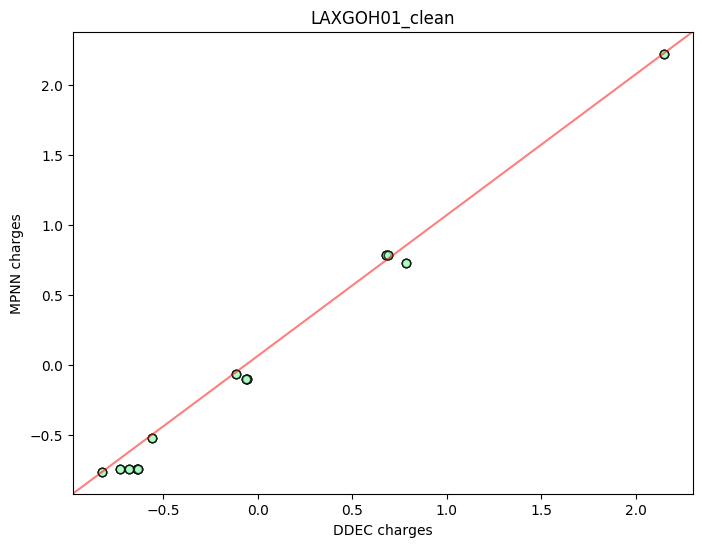

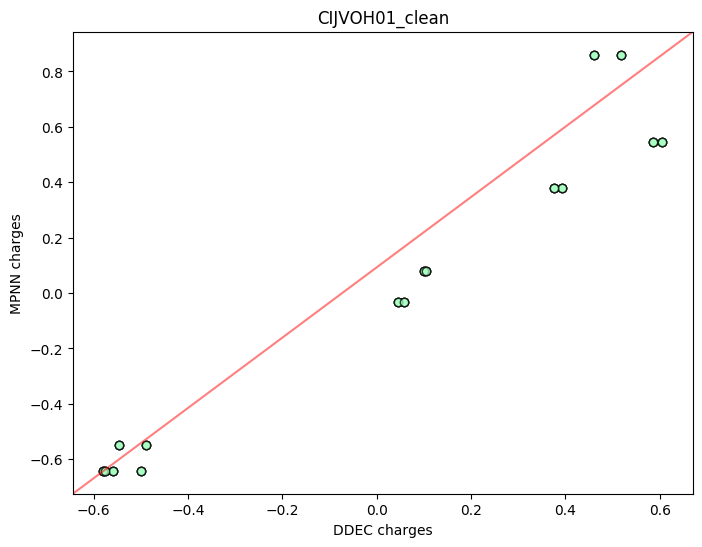

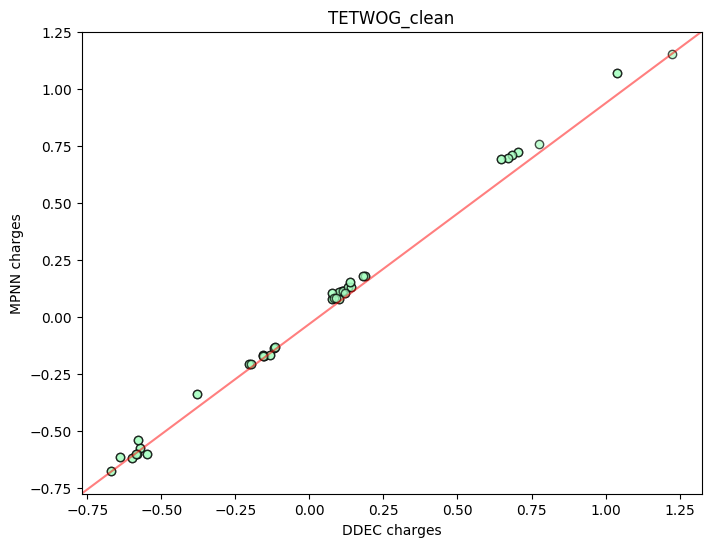

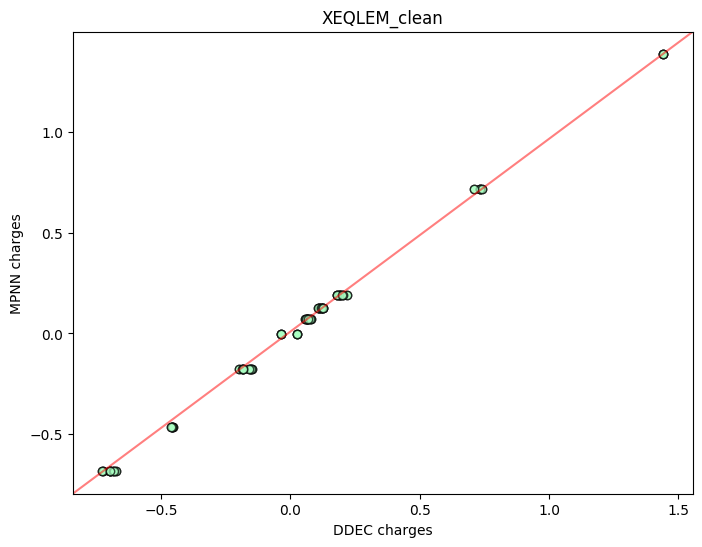

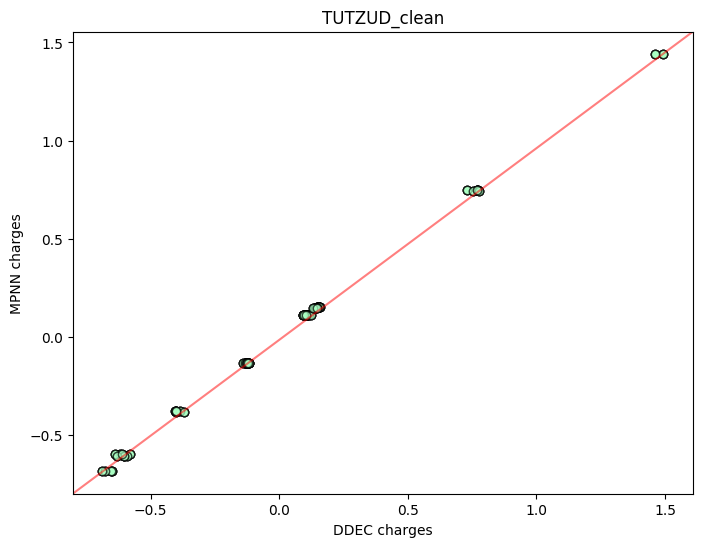

In [5]:
for xtalname in shuffle(collect(intersect_xtals))[1:5]
    @eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "..", "build_graphs", "ddec_xtals")
    ddec_xtal = Crystal(xtalname * ".cif", check_neutrality=false, check_overlap=false)
    strip_numbers_from_atom_labels!(ddec_xtal)
    
    @eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "..", "Charge_Assigned_CoRE_MOFs", "MPNN_CoRE-ASR")
    mpnn_xtal = Crystal(xtalname * ".cif", check_neutrality=false, check_overlap=false)
    strip_numbers_from_atom_labels!(mpnn_xtal)
    
    if !all(ddec_xtal.atoms.species .== mpnn_xtal.atoms.species)
        continue
    end
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(ddec_xtal.charges.q, mpnn_xtal.charges.q, ec="k", fc="#aaffc3", alpha=0.7)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, ylim, c="r", alpha=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("DDEC charges")
    ax.set_ylabel("MPNN charges")
    ax.set_title(xtalname)
end